In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import environment
import importlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import SGD

<Figure size 720x720 with 0 Axes>

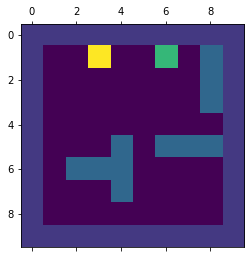

In [92]:
importlib.reload(environment)
e = environment.DQNEnv()
e.render()

In [93]:
# Neural Network Management
NN1 = False
NN2 = True

#define radius
radius = 3
mx = (radius*2+1)**2 + 4  # number fields + coordinates position & finish
my = 1

In [94]:
# NN (don't work so far)
if(NN1): 
    model = keras.Sequential()
    # input ...
    model.add(keras.Input(shape=(29,)))
    model.add(layers.Dense(20, activation="relu"))
    model.add(layers.Dense(20, activation="relu"))
    #model.add(layers.Dense(20, activation="softmax"))
    model.add(layers.Dense(4))

    #sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9)
    sgd = tf.keras.optimizers.SGD(
        learning_rate=0.01, momentum=0.0, nesterov=False, name="SGD"
    )
    #model.compile(optimizer=sgd, loss = 'mse')
    model.compile(SGD(lr=0.01), 'mse')

In [95]:
if(NN2):
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.optimizers import SGD
    model = Sequential()
    model.add(Dense(20, input_shape=(mx*my,), activation='relu'))  # TODO: Use input as 2d array.
    model.add(Dense(20, activation='relu'))  # TODO: Use input as 2d array.
    model.add(Dense(4))
    model.compile(SGD(lr=0.001), 'mse')

In [96]:
#epsilon = 0.05  # probability to choose random action instead of best action
gamma = 0.95
batch_size = 150
memory_size = 1000
max_num_steps = 100

In [97]:
memory = []
memory_lens = []
history = []
loss = []
t_rewards = []
t_time = []

In [98]:
verbose = False

len_ = 1
num_epochs = 10
startpos = e.get_pos()
print(startpos)
for epoch,epsilon in zip(range(num_epochs), np.linspace(1.,0.05, num_epochs)): 
    e.reset_pos(startpos)
    state = e.get_state(radius)
    done = False
    dead = False
    loss_epoch = []
    rewards_epoch = []
    time = 0
    reward = 0
    
    while not done and not dead and time < max_num_steps: 
        time +=1
        
        if np.random.rand() <= epsilon: 
            action = np.random.randint(4)
            if verbose: print('choosing random action {} ,'.format(action))
        else: 
            Q = model.predict(state.reshape(1, -1))
            action = np.argmax(Q)
            if verbose: print('choosing best action {} ,'.format(action))
                
        n_state, reward, done, dead = e.step_f(action, radius)
        if verbose: print('reward {}'.format(reward))
        
        memory.append([state,action,reward,n_state, done])
        if verbose: print('Memory {}',format(memory[-1]))
        
        while len(memory) > memory_size:  # only keep the most recent experiences in memory
            del memory[0]
        
        # Replay memories and train network.
        actual_batch_size = min(batch_size, len(memory))
        inputs = np.zeros((actual_batch_size, mx * my))
        targets = np.zeros((actual_batch_size, 4))
        
        for i, j in enumerate(np.random.choice(len(memory), size=actual_batch_size, replace=False)):
            s, a, r, new_s, d = memory[j]
            inputs[i] = s.flatten()
            if verbose: print("Inputs: "+ str(inputs[i]))
            Q = model.predict(s.reshape(1, -1))[0]
            targets[i] = Q
            if done:
                targets[i, a] = r
                if verbose: print(targets[i, a])
            else:
                Q_new = model.predict(new_s.reshape(1, -1))[0]
                targets[i, a] = r + gamma * np.max(Q_new)
                if verbose: print("Target:" + str(targets[i, a]))
        loss_epoch.append(model.train_on_batch(inputs, targets))
        rewards_epoch.append(reward)
        #print(np.sum(rewards_epoch))
        state = n_state
        
    print('Epoch {} - loss {} - {} {} steps - final reward {} - total reward {}'.format(epoch, np.mean(loss_epoch), 'solved in' if done else 'aborted or dead after', time, reward, np.sum(rewards_epoch)))
    loss.append(np.mean(loss_epoch))
    t_rewards.append(np.sum(rewards_epoch))
    t_time.append(time)         

(1, 6)
Epoch 0 - loss 5.679988384246826 - aborted or dead after 100 steps - final reward -10 - total reward -640
Epoch 1 - loss 2.224864959716797 - aborted or dead after 100 steps - final reward -10 - total reward -370
Epoch 2 - loss 2.4586124420166016 - aborted or dead after 100 steps - final reward -10 - total reward -430
Epoch 3 - loss 2.0327696800231934 - aborted or dead after 100 steps - final reward -10 - total reward -410
Epoch 4 - loss 1.7409958839416504 - aborted or dead after 100 steps - final reward 0 - total reward -230
Epoch 5 - loss 1.608498215675354 - aborted or dead after 100 steps - final reward -10 - total reward -390
Epoch 6 - loss 1.324967622756958 - aborted or dead after 100 steps - final reward 0 - total reward -180
Epoch 7 - loss 1.1661980152130127 - aborted or dead after 100 steps - final reward 0 - total reward -130
Epoch 8 - loss 1.094338297843933 - aborted or dead after 100 steps - final reward 0 - total reward -10
Epoch 9 - loss 0.9347092509269714 - aborted 